In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    # "/storage/vbutoi/scratch/ESE/calibration/10_01_24_ISLES_3D_LTS_HugeAugedRuns",
    "/storage/vbutoi/scratch/ESE/calibration/10_06_24_ISLES_3D_SCTS_PredTemp_Small_wNorm_Bs8_LrSweep",
    # "/storage/vbutoi/scratch/ESE/calibration/10_02_24_ISLES_3D_SCTS_Small_wSigmoid",
    # "/storage/vbutoi/scratch/ESE/calibration/10_06_24_ISLES_3D_SCTS_PredTemp_Small_wNorm",
    # "/storage/vbutoi/scratch/ESE/calibration/10_02_24_ISLES_3D_SCTS_Big_LR_Sweep",
]

df_list_1 = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list_1.append(df)
    except Exception as e:
        print(e)

df = pd.concat(df_list_1)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
df['lr'].unique()

array([0.0003, 0.0001])

In [4]:
# for ikey in df.keys():
#     print(ikey)

In [5]:
# Subselect the pretrained dir
df = df[df['base_pretrained_dir'] == '/storage/vbutoi/scratch/ESE/training/09_25_24_ISLES_3D_Dice_HeavyAug/20240925_234556-HGRQ-56cd3bf7df7a1b7d2a453b296d64407d']

In [6]:
# Limit the rows to those with lr = 1e-5
# df = df[df['lr'] == 1e-5]

In [7]:
def exp_name(path):
    exp_root = str(path).split("/")[-2]
    return exp_root

def aug_type(path):
    exp_root = str(path).split("/")[-2]
    if exp_root == "09_26_24_ISLES_3D_LTS_AllAug_v2_ElasticOnly":
        exp_n = "spatial"
    elif exp_root == "09_26_24_ISLES_3D_LTS_AllAugBackbone_v2":
        exp_n = "intensity + spatial"
    else:
        raise ValueError("Unknown experiment root")
    return exp_n

def norm_type(path):
    exp_root = str(path).split("/")[-2]
    if exp_root == "09_27_24_ISLES_3D_LTS_Bs6_lr1e-4_BATCHNORM":
        exp_n = "batch"
    elif exp_root == "09_27_24_ISLES_3D_LTS_Bs6_lr1e-4_LAYERNORM":
        exp_n = "layer"
    else:
        exp_n = "None"
    return exp_n

df.augment(exp_name)
# df.augment(aug_type)
df.augment(norm_type)

In [8]:
# we need to make batch_size and lr cateogorical variables
df['batch_size'] = df['batch_size'].astype('category')
df['lr'] = df['lr'].astype('category')

In [9]:
# We want to make sure that train goes before val in the phase
df['phase'] = df['phase'].astype('category')
df['phase'].cat.reorder_categories(['train', 'val'], inplace=True)

<ipython-input-9-ee3f85ac4261>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df['phase'].cat.reorder_categories(['train', 'val'], inplace=True)


In [10]:
# # We only want to include the runs corresponding to 0.0001 or 0.0005
# df = df[df['lr'].isin([0.0001, 0.0005])]

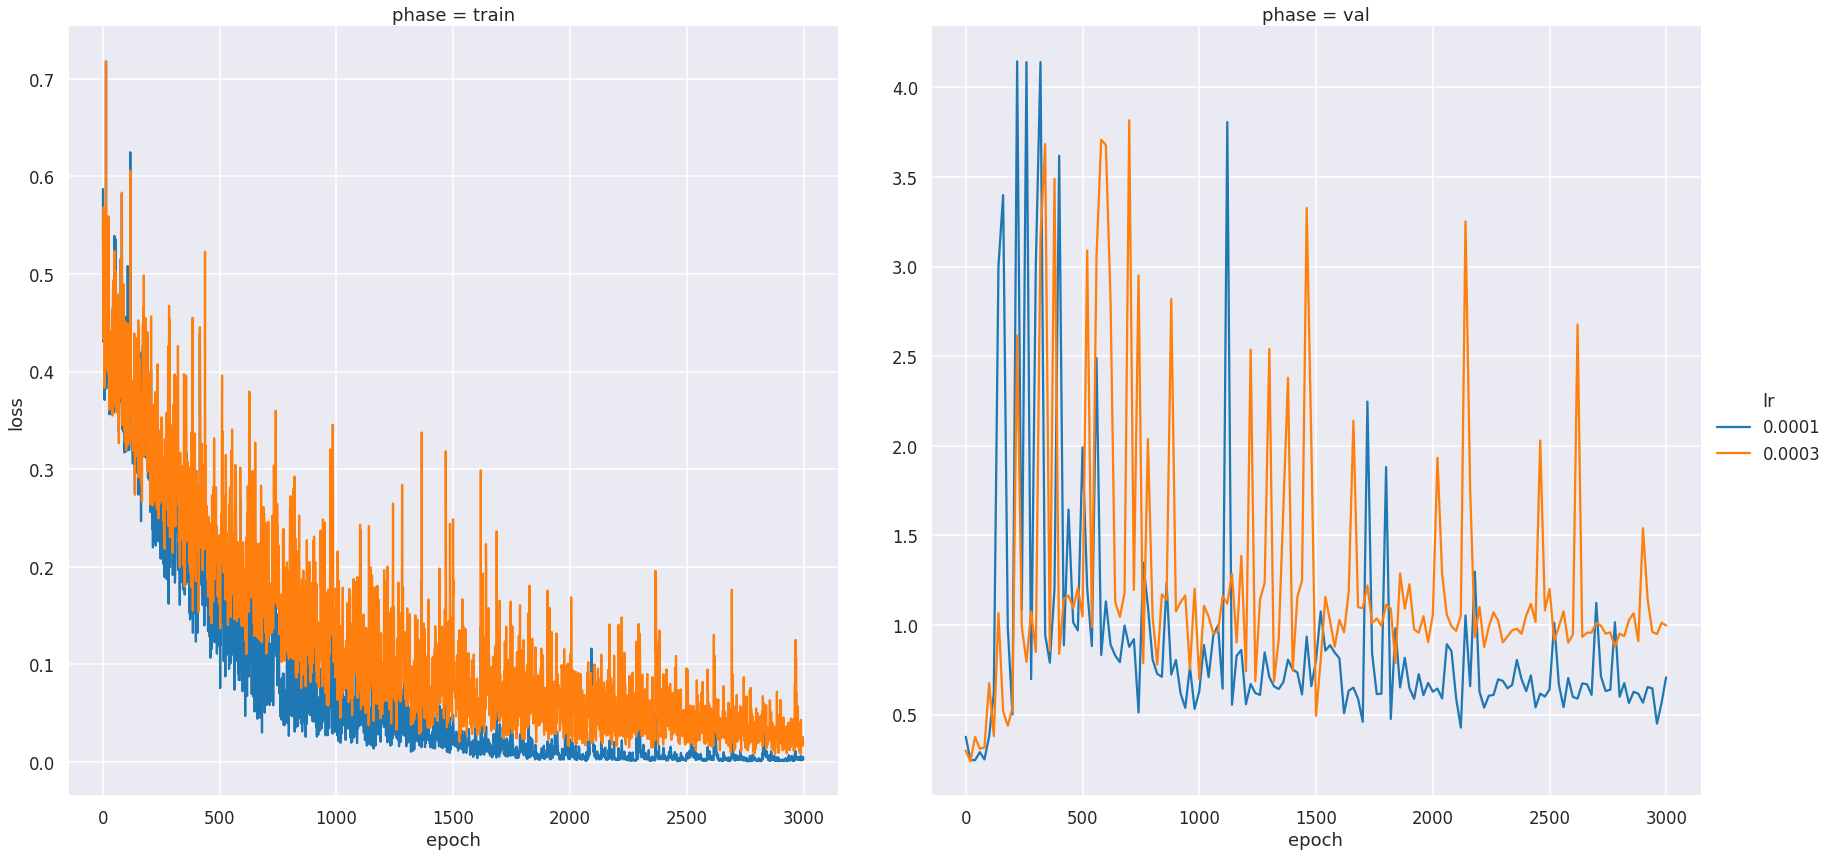

In [11]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='lr',
    # hue='exp_name',
    # style='lr',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.12)
# Set the y axis to be between 0 and 1
# g.set(ylim=(0, 1))

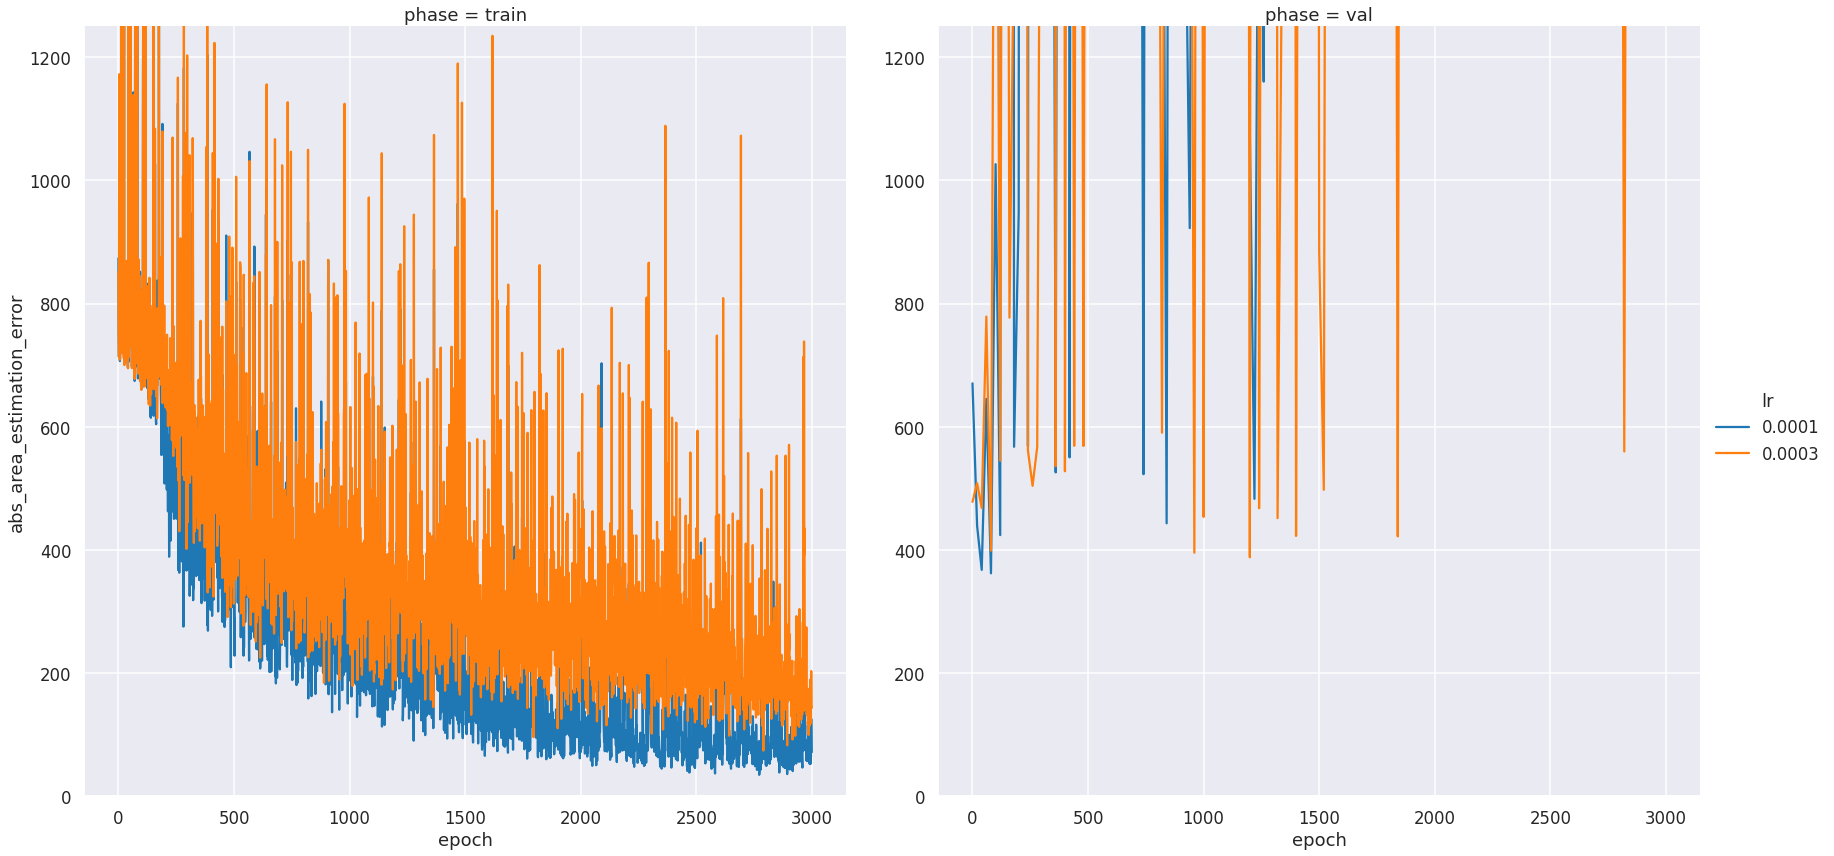

In [12]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='abs_area_estimation_error',
    hue='lr',
    # hue='exp_name',
    # style='lr',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacig
g.fig.subplots_adjust(wspace=0.12)
# Set the y lim
g.set(ylim=(0, 1250))

In [13]:
reduced_lr_df = df[df['lr'] == 1e-5]

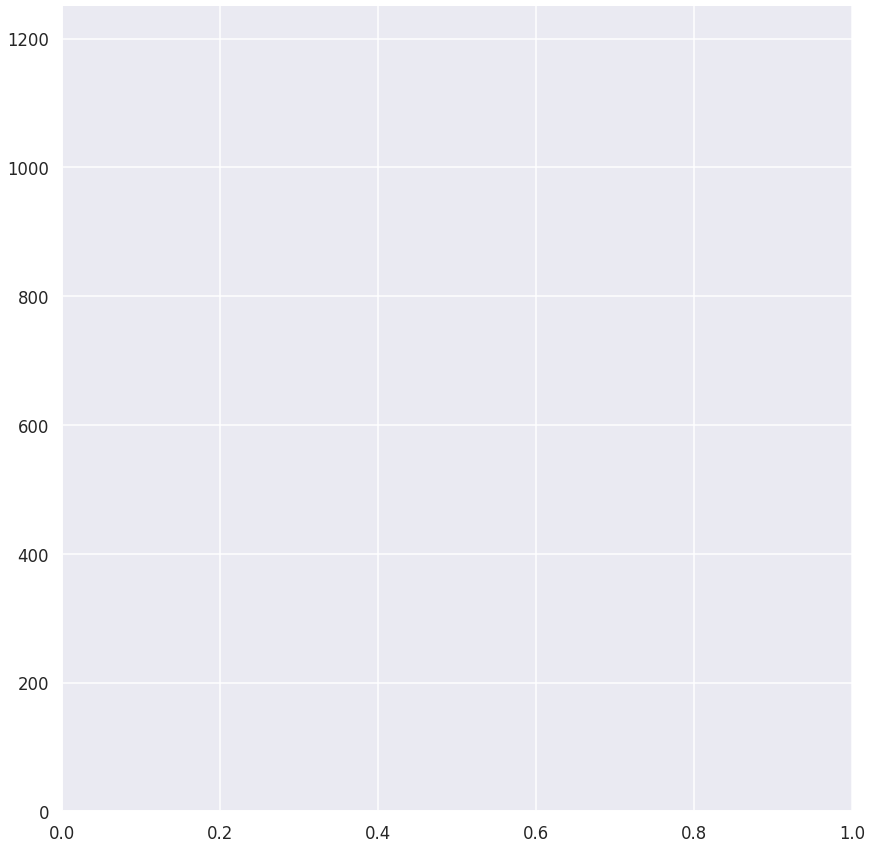

In [14]:
g = sns.relplot(
    data=reduced_lr_df,
    x='epoch',
    y='abs_area_estimation_error',
    hue='exp_name',
    style='lr',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacig
g.fig.subplots_adjust(wspace=0.12)
# Set the y lim
g.set(ylim=(0, 1250))

In [15]:
reduced_lr_df_pt2 = df[df['lr'] == 1e-4]

In [16]:
# Subselect the df to include only ever 20 epochs
reduced_lr_df_pt2 = reduced_lr_df_pt2[reduced_lr_df_pt2['epoch'] % 40 == 0]

def calibrator(exp_name):
    if "LTS" in exp_name:
        return "LTS"
    elif "PredTemp" in exp_name:
        return "Direct Temp Predictor"
    else:
        return "Naive Temp Predictor"
reduced_lr_df_pt2.augment(calibrator)

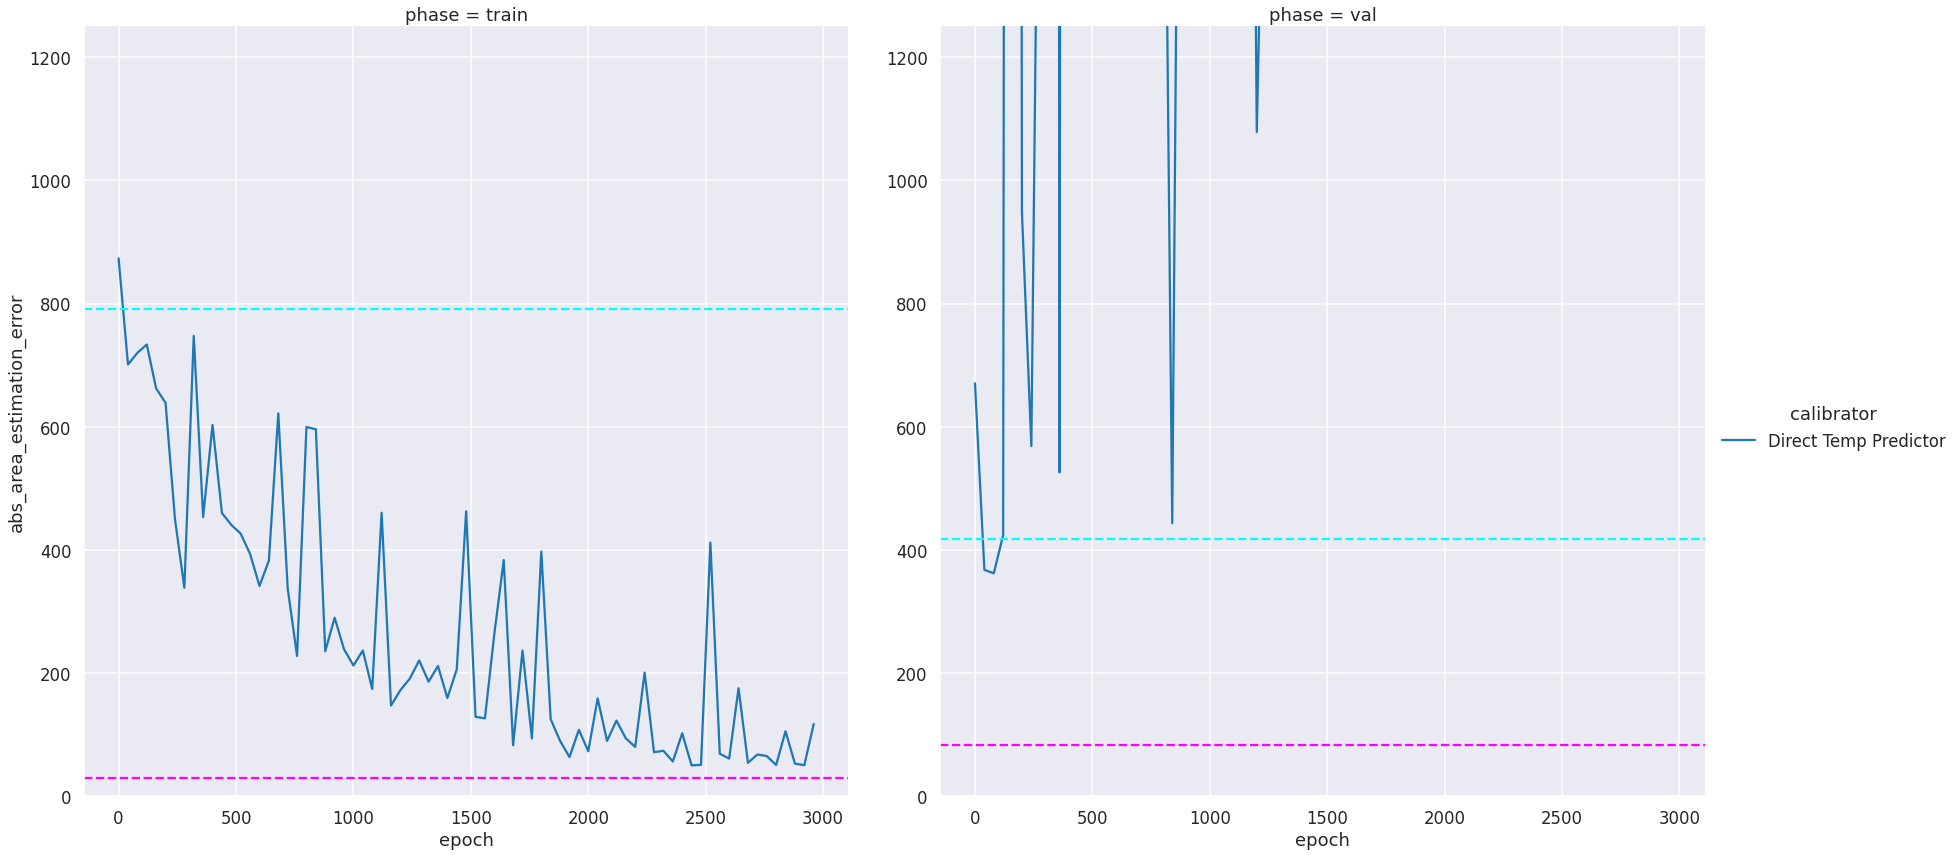

In [17]:
g = sns.relplot(
    data=reduced_lr_df_pt2,
    x='epoch',
    y='abs_area_estimation_error',
    hue='calibrator',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacig
g.fig.subplots_adjust(wspace=0.12)
# Set the y lim
g.set(ylim=(0, 1250))

# THESE CORRESPOND TO THE GROUND TRUTH BEST OPTIMAL TEMPERATURES.
# - Add a horizontal line on the first subplot at y = 791.7
# - Add a horizontal line on the second subplot at y = 418.1
g.axes[0, 0].axhline(791.7, ls='--', color='cyan', label='791.7')
g.axes[0, 1].axhline(418.1, ls='--', color='cyan', label='418.1')

# THESE CORRESPOND TO THE BEST PER-SUBJECT OPTIMAL TEMPERATURES.
# - Add a horizontal line on the first subplot at y = 29.6
# - Add a horizontal line on the second subplot at y =  83.7
g.axes[0, 0].axhline(29.6, ls='--', color='magenta', label='29.6')
g.axes[0, 1].axhline(83.7, ls='--', color='magenta', label='83.7')